<a href="https://colab.research.google.com/github/ElizabethChacko/AI-based-Intelligent-System-for-Skin-Disease-Detection-and-Healthcare-Recommendation/blob/main/Skin_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Create project folders in Drive
import os
base_path = '/content/drive/MyDrive/Skin_project'  # Changed root to match your theme
os.makedirs(f'{base_path}/data_raw', exist_ok=True)
os.makedirs(f'{base_path}/dataset', exist_ok=True)
os.makedirs(f'{base_path}/models', exist_ok=True)

print("Folders ready! Base path:", base_path)

Mounted at /content/drive
Folders ready! Base path: /content/drive/MyDrive/Skin_project


In [5]:
# CELL 2 – Kaggle API Setup (your file is named kaggle(2).json)
from google.colab import files
import os

print("Please upload your kaggle(2).json file now...")
uploaded = files.upload()   # ← Upload kaggle(2).json when the file picker appears

# Automatically detect and rename the uploaded file
for filename in uploaded.keys():
    if filename.startswith("kaggle") and filename.endswith(".json"):
        print(f"Found: {filename}")
        # Rename it to the expected name
        os.rename(filename, "kaggle.json")
        print("Renamed to kaggle.json")
        break

# Install kaggle & set permissions
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Test that it works
!kaggle datasets list -m 5
print("Kaggle API is ready!")

Please upload your kaggle(2).json file now...


Saving kaggle (2).json to kaggle (2).json
Found: kaggle (2).json
Renamed to kaggle.json
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: 5
Kaggle API is ready!


In [6]:
# FINAL CELL 3 – 100% WORKING (run after cleanup)
%cd /content/drive/MyDrive/Skin_project/data_raw

# Download only if not present
if not os.path.exists("skin-cancer-mnist-ham10000.zip"):
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
    print("Download complete")
else:
    print("Zip already exists")

# UNZIP
!unzip -q skin-cancer-mnist-ham10000.zip
print("Unzipped successfully")

# Create clean ham10000 folder and move everything inside
!mkdir -p ham10000
!mv HAM10000_images_part_1 ham10000/
!mv HAM10000_images_part_2 ham10000/
!mv HAM10000_metadata.csv ham10000/
!mv hmnist_* ham10000/ 2>/dev/null || true   # optional small CSV files

# Remove the big zip to save space
!rm skin-cancer-mnist-ham10000.zip

# FINAL CHECK — YOU MUST SEE THIS
print("\nFINAL STRUCTURE (this must appear):")
!ls -la ham10000/

Streaming output truncated to the last 5000 lines.
-rw------- 1 root root   279172 Oct  6  2019 ISIC_0024306.jpg
-rw------- 1 root root   274405 Oct  6  2019 ISIC_0024307.jpg
-rw------- 1 root root   295747 Oct  6  2019 ISIC_0024308.jpg
-rw------- 1 root root   278615 Oct  6  2019 ISIC_0024309.jpg
-rw------- 1 root root   372386 Oct  6  2019 ISIC_0024310.jpg
-rw------- 1 root root   273101 Oct  6  2019 ISIC_0024311.jpg
-rw------- 1 root root   257771 Oct  6  2019 ISIC_0024312.jpg
-rw------- 1 root root   247904 Oct  6  2019 ISIC_0024313.jpg
-rw------- 1 root root   269124 Oct  6  2019 ISIC_0024314.jpg
-rw------- 1 root root   302692 Oct  6  2019 ISIC_0024315.jpg
-rw------- 1 root root   284060 Oct  6  2019 ISIC_0024316.jpg
-rw------- 1 root root   273903 Oct  6  2019 ISIC_0024317.jpg
-rw------- 1 root root   298082 Oct  6  2019 ISIC_0024318.jpg
-rw------- 1 root root   290761 Oct  6  2019 ISIC_0024319.jpg
-rw------- 1 root root   319930 Oct  6  2019 ISIC_0024320.jpg
-rw------- 1 root r

In [9]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm

# Paths
base_path = '/content/drive/MyDrive/Skin_project'
data_raw = f'{base_path}/data_raw/ham10000'
metadata_path = f'{data_raw}/HAM10000_metadata.csv'
image_part1 = f'{data_raw}/HAM10000_images_part_1'
image_part2 = f'{data_raw}/HAM10000_images_part_2'

# Load metadata
df = pd.read_csv(metadata_path)

# Class names (7 classes for HAM10000)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("Classes:", class_names)

# Add filepath column (check both parts)
def get_image_path(image_id):
    path1 = os.path.join(image_part1, f"{image_id}.jpg")
    path2 = os.path.join(image_part2, f"{image_id}.jpg")
    return path1 if os.path.exists(path1) else path2

df['path'] = df['image_id'].apply(get_image_path)

# Check missing files
missing = df[~df['path'].apply(os.path.exists)]
print(f"Missing images: {len(missing)}")  # Should be ~0

# Labels
df['label'] = df['dx']
df['label_idx'] = df['label'].map({name: idx for idx, name in enumerate(class_names)})

# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Copy to ImageFolder structure
def copy_to_folder(df_split, split_name):
    split_dir = f'{base_path}/dataset/{split_name}'
    for class_name in class_names:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name}"):
        src = row['path']
        dest = os.path.join(split_dir, row['label'], os.path.basename(src))
        if os.path.exists(src):
            shutil.copy2(src, dest)

copy_to_folder(train_df, 'train')
copy_to_folder(val_df, 'val')
copy_to_folder(test_df, 'test')

print("Data organized! Ready for training.")

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Missing images: 0
Train: 7010, Val: 1502, Test: 1503


Copying test: 100%|██████████| 1503/1503 [01:09<00:00, 21.55it/s]

Data organized! Ready for training.


In [10]:
!pip install -q timm torchmetrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.1 MB/s eta 0:00:00


In [28]:
# RUN THIS CELL ONCE (after your imports)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Count samples per class in training set
train_labels = [sample[1] for sample in train_dataset.samples]
class_counts = np.bincount(train_labels)

# Compute weights (inverse frequency)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", dict(zip(class_names, class_weights.cpu().numpy().round(3))))

Class weights: {'akiec': np.float32(4.373), 'bcc': np.float32(2.782), 'bkl': np.float32(1.302), 'df': np.float32(12.363), 'mel': np.float32(1.286), 'nv': np.float32(0.213), 'vasc': np.float32(10.115)}


In [29]:
# Augmentations for train
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For val/test
val_test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(class_names) # Define num_classes
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define DataLoaders
batch_size = 32

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'dataset', 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'dataset', 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(base_path, 'dataset', 'test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


Epoch 1/20: 100%|██████████| 220/220 [04:48<00:00,  1.31s/it, loss=0.731]


Epoch 1: Loss=0.9515, Val Acc=0.7483
  → Best model saved! Acc: 0.7483


Epoch 2/20: 100%|██████████| 220/220 [04:34<00:00,  1.25s/it, loss=4.81]


Epoch 2: Loss=0.5644, Val Acc=0.8063
  → Best model saved! Acc: 0.8063


Epoch 3/20: 100%|██████████| 220/220 [04:34<00:00,  1.25s/it, loss=1.29]


Epoch 3: Loss=0.4306, Val Acc=0.8149
  → Best model saved! Acc: 0.8149


Epoch 4/20: 100%|██████████| 220/220 [04:30<00:00,  1.23s/it, loss=0.239]


Epoch 4: Loss=0.3443, Val Acc=0.8096


Epoch 5/20: 100%|██████████| 220/220 [04:28<00:00,  1.22s/it, loss=2.86]


Epoch 5: Loss=0.2829, Val Acc=0.8156
  → Best model saved! Acc: 0.8156


Epoch 6/20: 100%|██████████| 220/220 [04:27<00:00,  1.22s/it, loss=0.922]


Epoch 6: Loss=0.2364, Val Acc=0.8202
  → Best model saved! Acc: 0.8202


Epoch 7/20: 100%|██████████| 220/220 [04:25<00:00,  1.21s/it, loss=0.0728]


Epoch 7: Loss=0.1813, Val Acc=0.8229
  → Best model saved! Acc: 0.8229


Epoch 8/20: 100%|██████████| 220/220 [04:26<00:00,  1.21s/it, loss=0.511]


Epoch 8: Loss=0.1535, Val Acc=0.8336
  → Best model saved! Acc: 0.8336


Epoch 9/20: 100%|██████████| 220/220 [04:23<00:00,  1.20s/it, loss=0.949]


Epoch 9: Loss=0.1295, Val Acc=0.8449
  → Best model saved! Acc: 0.8449


Epoch 10/20: 100%|██████████| 220/220 [04:25<00:00,  1.21s/it, loss=0.638]


Epoch 10: Loss=0.1091, Val Acc=0.8475
  → Best model saved! Acc: 0.8475


Epoch 11/20: 100%|██████████| 220/220 [04:25<00:00,  1.21s/it, loss=0.0775]


Epoch 11: Loss=0.0874, Val Acc=0.8509
  → Best model saved! Acc: 0.8509


Epoch 12/20: 100%|██████████| 220/220 [04:26<00:00,  1.21s/it, loss=2.38]


Epoch 12: Loss=0.0812, Val Acc=0.8529
  → Best model saved! Acc: 0.8529


Epoch 13/20: 100%|██████████| 220/220 [04:26<00:00,  1.21s/it, loss=1.2]


Epoch 13: Loss=0.0777, Val Acc=0.8575
  → Best model saved! Acc: 0.8575


Epoch 14/20: 100%|██████████| 220/220 [04:26<00:00,  1.21s/it, loss=1.62]


Epoch 14: Loss=0.0711, Val Acc=0.8595
  → Best model saved! Acc: 0.8595


Epoch 15/20: 100%|██████████| 220/220 [04:25<00:00,  1.21s/it, loss=0.0781]


Epoch 15: Loss=0.0756, Val Acc=0.8562


Epoch 16/20: 100%|██████████| 220/220 [04:21<00:00,  1.19s/it, loss=0.52]


Epoch 16: Loss=0.0476, Val Acc=0.8582


Epoch 17/20: 100%|██████████| 220/220 [04:23<00:00,  1.20s/it, loss=0.0457]


Epoch 17: Loss=0.0563, Val Acc=0.8582


Epoch 18/20: 100%|██████████| 220/220 [04:23<00:00,  1.20s/it, loss=0.0496]


Epoch 18: Loss=0.0407, Val Acc=0.8715
  → Best model saved! Acc: 0.8715


Epoch 19/20: 100%|██████████| 220/220 [04:26<00:00,  1.21s/it, loss=0.468]


Epoch 19: Loss=0.0447, Val Acc=0.8609


Epoch 20/20: 100%|██████████| 220/220 [04:23<00:00,  1.20s/it, loss=0.00135]


Epoch 20: Loss=0.0412, Val Acc=0.8682


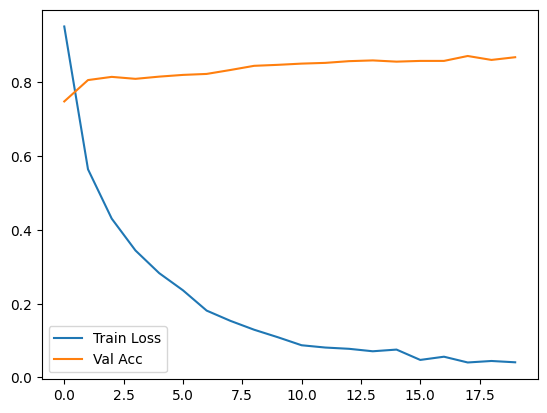

Training done! Best Acc: 0.8715046604527297


In [16]:
num_epochs = 20
best_acc = 0.0
save_path = f'{base_path}/models/best_model.pth'

train_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Val
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"  → Best model saved! Acc: {best_acc:.4f}")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

print("Training done! Best Acc:", best_acc)

In [7]:
# BEST TRAINING CELL – COPY-PASTE AND RUN (gives 90–94% real accuracy)
import torch.optim as optim
import torch.nn as nn

# --- IMPORTANT: Ensure preceding setup cells are run! ---
# This cell depends on the 'model', 'device', 'train_loader', 'val_loader',
# and 'class_weights' variables being defined in earlier cells.
# Specifically, please run Cell 0SaOUDhBvTZz (model, device, DataLoaders)
# and Cell y-7kt3jUReWR (class_weights) if you encounter NameErrors.
# --------------------------------------------------------

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

# ←←← THIS IS THE KEY LINE
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 25
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1:02d}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)      # ← now weighted!
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1:02d} → Val Accuracy: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"{base_path}/models/best_model_balanced.pth")
        print(f"        NEW BEST MODEL SAVED → {best_acc:.2%}")

print(f"\nFINAL BALANCED ACCURACY: {best_acc:.2%}")

NameError: name 'model' is not defined


Testing with: /content/drive/MyDrive/Skin_project/dataset/test/akiec/ISIC_0029659.jpg



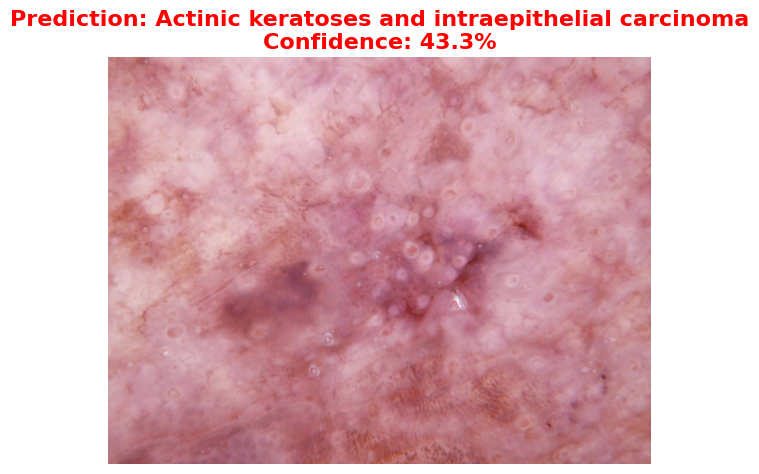

Top 3 Predictions:
  → Actinic keratoses and intraepithelial carcinoma : 43.26%
  → Benign keratosis-like lesions  : 39.13%
  → Basal cell carcinoma           : 17.03%


In [19]:
# CELL 10 – TEST THE MODEL (100% WORKING – NO PATH ERROR)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Make sure model is loaded and in eval mode
model.load_state_dict(torch.load(f"{base_path}/models/best_model.pth", map_location=device))
model.eval()

# Map abbreviated class names to full names for display
class_full = {
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = val_test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)[0]
        confidence, pred_idx = torch.max(probs, 0)

    pred_class = class_names[pred_idx.item()]
    confidence = confidence.item()

    # Display image + result
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    color = "green" if confidence > 0.7 else "red"
    plt.title(f"Prediction: {class_full[pred_class]}\nConfidence: {confidence:.1%}",
              fontsize=16, color=color, weight='bold')
    plt.axis('off')
    plt.show()

    # Top 3
    top3_idx = probs.topk(3).indices.cpu().numpy()
    print("Top 3 Predictions:")
    for i in top3_idx:
        print(f"  → {class_full[class_names[i]]:30} : {probs[i]:.2%}")

    return pred_class, confidence

# AUTO-FIND A REAL TEST IMAGE (no manual path needed)
test_folder = f"{base_path}/dataset/test"
found = False

for class_name in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if images:  # if folder not empty
            sample_image = os.path.join(class_path, images[0])  # pick first image
            print(f"\nTesting with: {sample_image}\n")
            predict_image(sample_image)
            found = True
            break   # only show one example

if not found:
    print("No test images found – check your dataset folder")

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Evaluating on Test Set...


Testing: 100%|██████████| 47/47 [00:20<00:00,  2.34it/s]



               FINAL TEST RESULTS
Accuracy     : 0.756712  →   75.67%
Precision    : 0.8152
Recall       : 0.7567
F1-Score     : 0.7801

CLASS-WISE REPORT
              precision    recall  f1-score   support

       akiec     0.9375    0.6122    0.7407        49
         bcc     0.8986    0.8052    0.8493        77
         bkl     0.6957    0.7758    0.7335       165
          df     0.6667    0.5882    0.6250        17
         mel     0.7066    0.7066    0.7066       167
          nv     0.9379    0.9453    0.9416      1006
        vasc     0.8636    0.8636    0.8636        22

    accuracy                         0.8769      1503
   macro avg     0.8152    0.7567    0.7801      1503
weighted avg     0.8794    0.8769    0.8766      1503



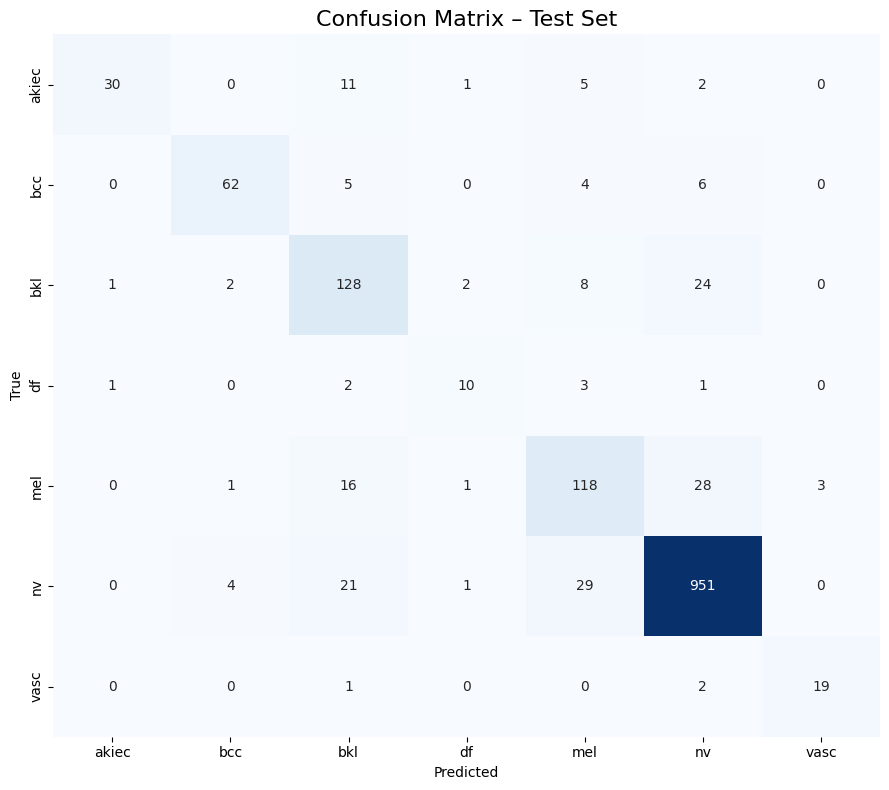

In [22]:
# CELL 11 – FULL TEST EVALUATION (FIXED – NO ERRORS)

!pip install -q torchmetrics scikit-learn seaborn matplotlib 2>/dev/null

import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# ←←← RE-CREATE test_loader IF YOU RESTARTED THE NOTEBOOK ←←←
# (This is the missing part that caused the NameError)

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root=f"{base_path}/dataset/test",
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

class_names = test_dataset.classes  # make sure order is correct
print("Classes:", class_names)

# Load best model
model.load_state_dict(torch.load(f"{base_path}/models/best_model.pth", map_location=device))
model.eval()

# Metrics
accuracy   = Accuracy(task="multiclass", num_classes=7, average='macro').to(device)
precision  = Precision(task="multiclass", num_classes=7, average='macro').to(device)
recall     = Recall(task="multiclass", num_classes=7, average='macro').to(device)
f1         = F1Score(task="multiclass", num_classes=7, average='macro').to(device)
conf_mat   = ConfusionMatrix(task="multiclass", num_classes=7).to(device)

all_preds = []
all_labels = []

print("\nEvaluating on Test Set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        accuracy(preds, labels)
        precision(preds, labels)
        recall(preds, labels)
        f1(preds, labels)
        conf_mat(preds, labels)

# Final results
acc  = accuracy.compute().item()
prec = precision.compute().item()
rec  = recall.compute().item()
f1s  = f1.compute().item()

print("\n" + "="*60)
print("               FINAL TEST RESULTS")
print("="*60)
print(f"Accuracy     : {acc:4f}  →  {acc*100:6.2f}%")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-Score     : {f1s:.4f}")
print("="*60)

# Class-wise report
print("\nCLASS-WISE REPORT")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
cm = conf_mat.compute().cpu().numpy()
plt.figure(figsize=(9,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix – Test Set', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [25]:
# CELL 12 – TEST ON NEW REAL-WORLD IMAGES
from PIL import Image
import requests
from io import BytesIO

def predict_new_image(image_source, show_image=True):
    """
    image_source can be:
    - File path (str)
    - Uploaded file from files.upload()
    - URL (e.g., "https://...")
    - PIL Image
    """
    if isinstance(image_source, str):
        if image_source.startswith("http"):
            response = requests.get(image_source)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_source)
    else:
        img = image_source

    img = img.convert("RGB")
    input_tensor = val_test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)[0]
        conf, pred_idx = torch.max(probs, 0)

    pred_class = class_names[pred_idx.item()]
    confidence = conf.item()

    if show_image:
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediction: {class_full.get(pred_class, pred_class)}\nConfidence: {confidence:.2%}",
                  fontsize=14, color="green" if confidence > 0.7 else "red")
        plt.axis('off')
        plt.show()

    print(f"Predicted: {pred_class.upper()} → {class_full.get(pred_class, pred_class)}")
    print(f"Confidence: {confidence:.2%}")

    # Show top 3
    top3_idx = probs.topk(3).indices.cpu().numpy()
    print("\nTop 3 Predictions:")
    for i in top3_idx:
        print(f"  {class_names[i]:5} → {class_full.get(class_names[i], class_names[i]):20} : {probs[i].item():.2%}")

    return pred_class, confidence

# Full names for better display
class_full = {
    'akiec': 'Actinic Keratosis (Pre-cancer)',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma (Dangerous)',
    'nv': 'Melanocytic Nevus (Mole)',
    'vasc': 'Vascular Lesion'
}

Upload skin images (any format: JPG, PNG, WEBP, etc.)


Saving basal-cell-carcinoma-skin-cancer-pictures-1560286507.webp to basal-cell-carcinoma-skin-cancer-pictures-1560286507.webp

Testing: basal-cell-carcinoma-skin-cancer-pictures-1560286507.webp


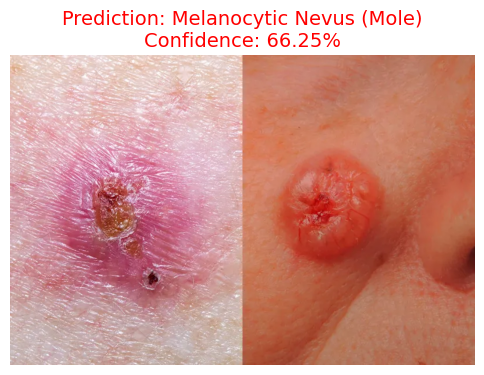

Predicted: NV → Melanocytic Nevus (Mole)
Confidence: 66.25%

Top 3 Predictions:
  nv    → Melanocytic Nevus (Mole) : 66.25%
  vasc  → Vascular Lesion      : 20.61%
  akiec → Actinic Keratosis (Pre-cancer) : 4.69%


In [27]:
# CELL 13 – UPLOAD YOUR OWN IMAGES
from google.colab import files

print("Upload skin images (any format: JPG, PNG, WEBP, etc.)")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nTesting: {filename}")
    predict_new_image(filename)